# Libraries

In [1]:
import gymnasium as gym
import pygame
from pygame.locals import K_LEFT, K_RIGHT, K_DOWN, QUIT
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Environment setup

In [2]:
env = gym.make("LunarLander-v2")#, render_mode="human")
observation, info = env.reset(seed=42)

# Hyperparameters

In [3]:
NUM_BINS = 20
EPOCHS = 20000
ALPHA = 0.8
GAMMA = 0.9
BURN_IN = 1
END_EPSILON_REDUCTION = 10000
EPSILON_REDUCE = 0.0001

# Playing the game manually

(uncomment the cell below if you want to try playing manually - you also need to specify `render_mode="human"` when creating the environment above)

pygame.init()
clock = pygame.time.Clock()
running = True
rewards = 0

while running:
    action = 0  # default action: do nothing

    for event in pygame.event.get():
        if event.type == QUIT:
            running = False

    keys = pygame.key.get_pressed()

    if keys[K_DOWN]:
        action = 2  # main engine
    elif keys[K_LEFT]:
        action = 3  # right engine
    elif keys[K_RIGHT]:
        action = 1  # left engine

    state, reward, done, truncated, info = env.step(action)
    rewards+=1
    env.render()

    if done:
        env.reset()
        print(f"You got {rewards} points!")
        rewards = 0

    clock.tick(30)  # limit the game to 30 FPS

env.close()
pygame.quit()


# Setting up Q-table

First, discretize the action space (for continuous actions at least)

In [4]:
limits = [(-1.5, 1.5), (-1.5, 1.5), (-5, 5), (-5, 5), (-3.1415927, 3.1415927), (-5, 5)]

In [5]:
def create_bins(num_bins_per_action=10):
    bins_x_coord = np.linspace(limits[0][0], limits[0][1], num_bins_per_action)
    bins_y_coord = np.linspace(limits[1][0], limits[1][1], num_bins_per_action)
    bins_x_linear_vel = np.linspace(limits[2][0], limits[2][1], num_bins_per_action)
    bins_y_linear_vel = np.linspace(limits[3][0], limits[3][1], num_bins_per_action)
    bins_angle = np.linspace(limits[4][0], limits[4][1], num_bins_per_action)
    bins_angular_vel = np.linspace(limits[5][0], limits[5][1], num_bins_per_action)
    bins = np.array([bins_x_coord, 
                     bins_y_coord, 
                     bins_x_linear_vel, 
                     bins_y_linear_vel,
                     bins_angle,
                     bins_angular_vel])
    return bins

In [6]:
BINS = create_bins(NUM_BINS)

In [7]:
def trim_outliers(observations):
    trimmed_observations = []
    for i in range(len(observations)):
        el = observations[i]
        if el < limits[i][0]:
            el = limits[i][0] + 1e-6
        elif el > limits[i][1]:
            el = limits[i][1] - 1e-6
        trimmed_observations.append(el)
    return trimmed_observations

In [8]:
def discretize_observation(observations, bins):
    binned_observations = []
    trimmed_observations = trim_outliers(observations)
    for i, observation in enumerate(trimmed_observations):
        discretized_observation = np.digitize(observation, bins[i])
        binned_observations.append(discretized_observation)
    return binned_observations

No need to discretize the final two dimensions of the state space (two booleans that represent whether each leg is in contact with the ground or not).

In [9]:
q_table_shape = (NUM_BINS, NUM_BINS, NUM_BINS, NUM_BINS, NUM_BINS, NUM_BINS, 2, 2, env.action_space.n)
q_table = np.zeros(q_table_shape)
print(q_table.shape)

(20, 20, 20, 20, 20, 20, 2, 2, 4)


# Setting up policy

In [10]:
def epsilon_greedy_action_selection(epsilon, q_table, discrete_state):
    random_number = np.random.random()  
    # EXPLOITATION
    if random_number > epsilon:
        action = np.argmax(q_table[discrete_state])
    # EXPLORATION
    else:
        # Return a random 0,1,2,3 action
        action = np.random.randint(0, env.action_space.n)
    return action

In [11]:
def compute_next_q_value(old_q_value, reward, next_optimal_q_value):    
    return old_q_value +  ALPHA * (reward + GAMMA * next_optimal_q_value - old_q_value)

In [12]:
def reduce_epsilon(epsilon, epoch):
    if BURN_IN <= epoch <= END_EPSILON_REDUCTION:
        epsilon-= EPSILON_REDUCE
    return epsilon

# Training the agent

In [13]:
epochs = []
rewards = []
rewards_rm = []
successes = []
successes_rm = []
epsilon = 1

In [15]:
for epoch in tqdm(range(EPOCHS)):
    initial_state, info = env.reset()  # get the initial observation
    discretized_state = tuple(discretize_observation(initial_state[0:6], BINS) + [int(initial_state[6]),int(initial_state[7])])  # map the observation to the bins
    terminated = False
    truncated = False  
    points = 0  # store result
    epochs.append(epoch)
    
    while not terminated and not truncated:
        action = epsilon_greedy_action_selection(epsilon, q_table, discretized_state)  # epsilon-greedy action selection 
        observation, reward, terminated, truncated, info = env.step(action)  # perform action and get next state

        next_state_discretized = tuple(discretize_observation(observation[0:6], BINS) + [int(observation[6]),int(observation[7])])  # map the next observation to the bins
        old_q_value =  q_table[discretized_state + (action,)]  # get the old Q-Value from the Q-Table
        next_optimal_q_value = np.max(q_table[next_state_discretized])  # Get the next optimal Q-Value
        
        next_q = compute_next_q_value(old_q_value, reward, next_optimal_q_value)  # Compute next Q-Value
        q_table[discretized_state + (action,)] = next_q  # Insert next Q-Value into the table

        discretized_state = next_state_discretized  # Update the old state
        points += 1

        if points >= 400:
            terminated = True # No need to keep the game running too long

    epsilon = reduce_epsilon(epsilon, epoch)  # Reduce epsilon
    rewards.append(points)  # log overall achieved points for the current epoch
    rewards_rm.append(np.mean(rewards[-300:]))  # Compute running mean points over the last 30 epochs
    successes.append(points>=200) # Has the agent scored at least 200 points?
    successes_rm.append(np.mean(successes[-300:]))

env.close()

100%|██████████| 20000/20000 [03:46<00:00, 88.34it/s]


# Visualizing results

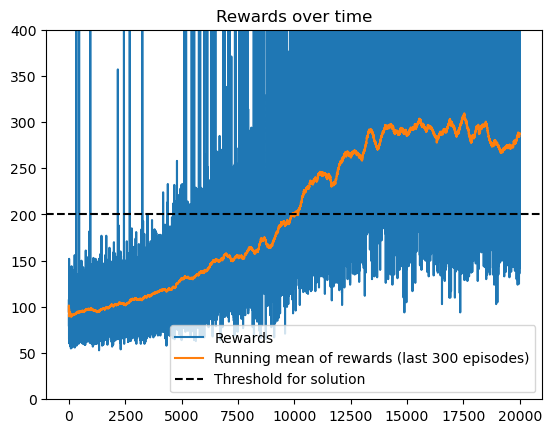

In [16]:
plt.plot(epochs, rewards, label='Rewards')
plt.plot(epochs, rewards_rm, label='Running mean of rewards (last 300 episodes)')
plt.title('Rewards over time')
plt.axhline(200, linestyle='dashed', color='black', label='Threshold for solution')
plt.ylim(0,400)
plt.legend()
plt.savefig('out/Q-table approach.png')
plt.show()

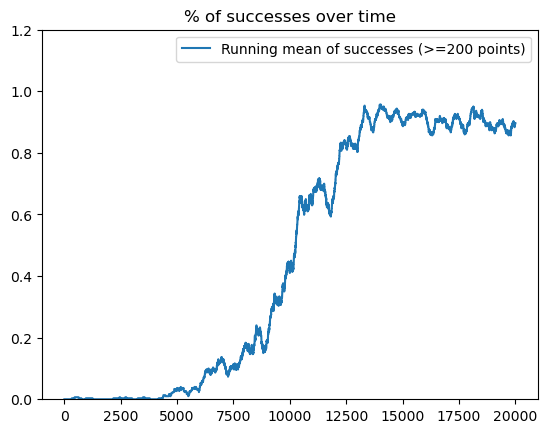

In [17]:
plt.plot(epochs, successes_rm, label='Running mean of successes (>=200 points)')
plt.title('% of successes over time')
plt.ylim(0,1)
plt.legend()
plt.savefig('out/Q-table approach - successes.png')
plt.show()